# Introduction to Programming:

## Group Project

This projects aims to develop a stock picking tool and to allocate the stocks such as to construct an optimized portfolio. The stocks selected are found with a simple sorting process based on fundamental stock data. 

The goal is to maximize the expected return on the investment.

To this purpose we need to identify companies with interesting profiles. We choose the firms that are above-average performers in a least two of the following criteria:

* Net Change in Cash
* Retained Earnings
* Dividends Paid
* Operating Income (Loss)
* Leverage

A company financial is considered above-average if it is $2\sigma$ away from the average, where $\sigma$ is the standard deviation. In the case of the leverage criteria, a company's leverage is considered low if its leverage is below average.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

#Import and concatenate the date (already sorted by the data provider)
path='C:\\Users\\Sipofo\\Desktop\\Mike\\A. Last semester!\\5. Skills Programming -Introduction\\Code\\'
filepaths = [f for f in listdir(path) if f.endswith('.csv')]
df=pd.concat([pd.read_csv(path+i, sep=";") for i in filepaths], axis=1,sort=True)
df = df.loc[:,~df.columns.duplicated()]
df=df.sort_values(["Ticker","Fiscal Year", "Fiscal Period"], ascending=True)

Calculation of the "leverage", and filter for Net Change in Cash, Retained Earnings, Dividends Paid, Operating Income (Loss) and Leverage.

In [31]:
df["Leverage"]=df["Total Liabilities"]/(df["Total Assets"]-df["Total Liabilities"])

target_columns=['Ticker','Fiscal Year','Fiscal Period','Net Change in Cash',
                'Retained Earnings','Dividends Paid',
                'Operating Income (Loss)', "Leverage"]

df = df.loc[:,target_columns]

Compare each company's average financial (except leverage) to the industry average. We select exclusively the firms which are at least two standard deviations away from the latter. To be selected, company must be above-average performers in at least two criteria.

In [32]:
threshold=(df.mean()[1:]+2*df.std()[1:]).to_frame().T
df=df.groupby(['Ticker'], as_index=False).mean()
df_values=pd.concat([df.iloc[:,items]-threshold.iloc[0, items-3] for items in range(3,len(df.columns)-1)],
         axis=1)

#Select only banks which fullfil at least two of the criteria
df_values=df_values[df_values>0]
df_values=df_values.dropna(thresh=2)
df_values=df_values.dropna(axis=1, how='all')
df_values["Ticker"]=df["Ticker"]
df_values["Leverage"]=df["Leverage"]

We further shrink our selection by choosing relatively low levels of leverage (defined as one standard deviations away from the mean).

In [33]:
selected_firms=df_values[df_values.Leverage<(np.mean(df_values.Leverage))]

We then have a selection of firms, which have in this case above-average retained earnings, above-average operating income and under average leverage.

Now that we have identified good companies with a relatively low risk profile, the next step is to figure out how much we are ready to invest in this portfolio. We use the Markowitz mean-variance model to this goal. 

First we need to collect historical prices. The prices are the adjusted closing prices which are gathered from Yahoo Finance.  We manually look for the stock market tickers which are associated to the companies we selected:

* BAC=BAC
* BBT=TFC
* BK=BK
* COF=COF
* DFS=DFS
* PNC=PNC
* USB=USB

In [34]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2018, 12, 31)
tickers = [string.replace('BBT','TFC') for string in selected_firms.Ticker]
df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

We visualize the monthly averages of the stock prices:

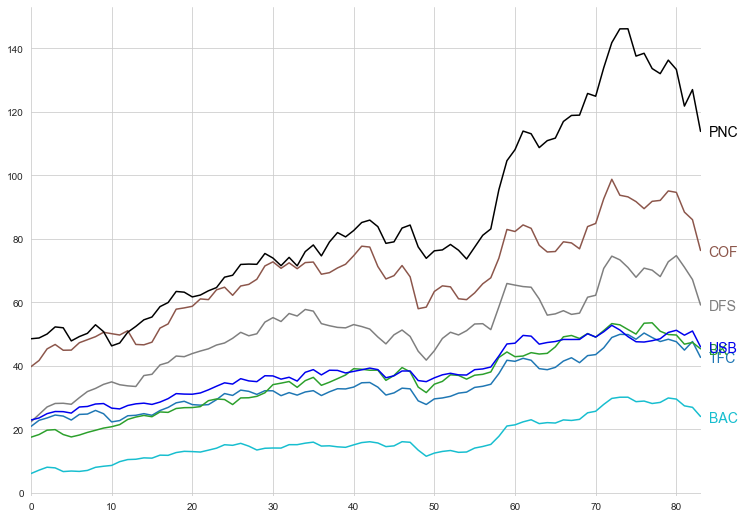

In [35]:
## Visualizing monthly stock prices
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(12,9))

df_month=df.groupby([df.index.year,df.index.month], as_index=False).mean()

#Preparing the axis.
ax = plt.subplot(111) 
positions=["top","bottom","right","left"]
for position in positions:
    ax.spines[position].set_visible(False)
    
#Preparing the colors
tableau = [(23, 190, 207), (31, 119, 180), (44, 160, 44), (140, 86, 75) , (127, 127, 127), (0,0,0), (0,0,238)] 
for scale in range(len(tableau)):    
    r, g, b = tableau[scale]    
    tableau[scale] = (r / 255., g / 255., b / 255.)    
      
#Plotting.
column_names=df.columns
labels=tickers
for rank, column in enumerate(column_names):  
    df_month[column].plot(lw="1.5", color=tableau[rank])  
    y_pos = df_month[column.replace("\n", " ")].values[-1]-2
    y_pos_last=y_pos.copy()
    if labels[rank] in column_names[rank]:
        y_pos+=0.3
        plt.text(len(df_month), y_pos, labels[rank], fontsize=14, color=tableau[rank]) 
plt.show()

The second step is to prepare the functions to calculate the mean, standard deviation and covariance matrix of the returns. The moments are computed such as presented in the Markowitz mean-variance model.

In [39]:
#Compute returns based on the weights, return, risk-free and covariance of the portfolios. The risk free rate serves
#to calculate the Sharpe ratio (Market portfolio)
def portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

#Simulate portfolios returns based on statistical moments we computed.
def random_portfolios(portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

Finally, we include realistic parameters and simulate the model performance. We choose to simulate 20000 portfolios.

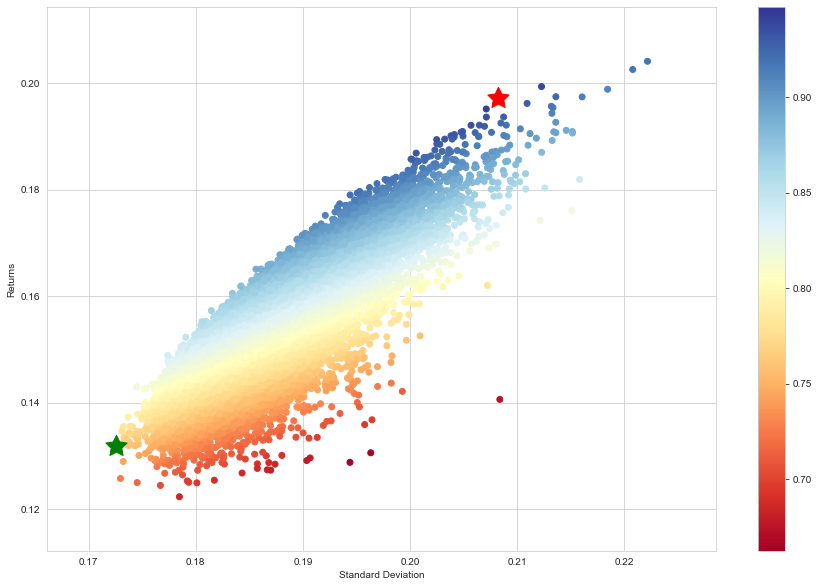

In [40]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
portfolios = 20000
rf = 0.0

results_frame = random_portfolios(portfolios, mean_returns, cov, rf)

#locate position of portfolio with highest Sharpe Ratio and minimum variance
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

#create scatter plot coloured by Sharpe Ratio level
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of portfolio with highest Sharpe Ratio adn green for minimum variance portfolio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()
plt.close()

The model advices us to invest in each of the stock the following weights into each of the stocks:

In [41]:
print(results_frame.iloc[results_frame['sharpe'].idxmax()])

ret       0.197209
stdev     0.208220
sharpe    0.947118
BAC       0.396827
TFC       0.021211
BK        0.099276
COF       0.011561
DFS       0.367213
PNC       0.045571
USB       0.058341
Name: 13516, dtype: float64


We want to test the model. The results of the portfolio analysis are for the period 2012-2018. Suppose that we have stationary market conditions such that the model weights remain valid over time. We can then use the Markowitz weights to seize our positions in future periods (in this case for the period 2019-2020).

We start with an initial wealth of 1000. The benchmark is the naive diversification method (equal weights investment approach).

First, we need to calculate the compound return from January 2019 to April 2020. Then, we can compare naive diversification method against the Markowitz approach.

In [42]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 4, 30)
tickers = [string.replace('BBT','TFC') for string in selected_firms.Ticker]
df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers
compounded_returns=(1+df.diff()/df).cumprod()
compounded_returns

,BAC,TFC,BK,COF,DFS,PNC,USB
Date,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.983713,0.993196,0.979811,0.985557,0.982880,0.995434,0.985777
2019-01-04,1.022939,1.018657,1.007420,1.027437,1.029065,1.019739,1.009564
2019-01-07,1.022138,1.026697,1.005102,1.033090,1.030741,1.017463,1.004798
2019-01-08,1.020135,1.029167,1.001302,1.033606,1.032585,1.019059,1.011224
...,...,...,...,...,...,...,...
2020-04-24,0.698299,0.600676,0.633199,0.488354,0.332914,0.683609,0.607951
2020-04-27,0.736680,0.632577,0.658739,0.513436,0.343673,0.714455,0.639806
2020-04-28,0.749631,0.633420,0.666842,0.550162,0.366150,0.717826,0.653248


A naive allocation of equal weight each would mean that we have a total wealth of:

In [43]:
naive_investment=(1000/len(tickers))*compounded_returns
naive_investment["Naive_wealth"]=naive_investment.sum(axis=1)

A Markowitz allocation would mean a wealth of:

In [44]:
markowitz_weights=results_frame[results_frame.index==results_frame['sharpe'].idxmax()][tickers]
markowitz_init=markowitz_weights*1000
markowitz_investment=compounded_returns.mul(markowitz_init.iloc[0], axis=1)
markowitz_investment["Markowitz_wealth"]=markowitz_investment.sum(axis=1)

Compare the two investment approaches:

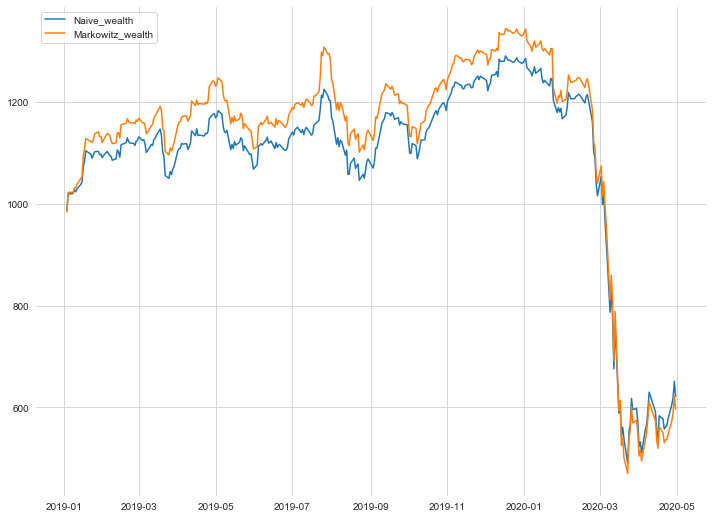

In [56]:
## Visualizing stock prices
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(12,9))

Wealth=pd.concat([naive_investment["Naive_wealth"],markowitz_investment["Markowitz_wealth"]], axis=1)

#Preparing the axis.
ax = plt.subplot(111) 
positions=["top","bottom","right","left"]
for position in positions:
    ax.spines[position].set_visible(False)
    
for column in Wealth.columns:
    plt.plot(Wealth[column][1:], label=column)

plt.legend(loc="upper left")
plt.show()
plt.close()

# Conclusion

We show that weights that are computed according to the Markowitz model are a better strategy than the naive diversification approach. However, the results of our analysis is only valid when markets are calm. In stressed periods, the Markowitz model fails.

An interesting fact of our analysis is to see that the Markowitz model consistently outperforms the naive diversification (1) when the market is calm and (2) even if the weights have been computed only once (e.g. there is no portfolio rebalancing).